<a href="https://colab.research.google.com/github/farhadabedinzadeh/ct-cov/blob/main/Another_copy_of_MainCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Necessary Libraries**


In [ ]:
import numpy as np
import pandas as pd

# PyTorch libraries and modules
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

# for reading and displaying images
import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

# for creating validation set
import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import os
import shutil

import requests
import zipfile
from io import BytesIO

# **Download Dataset from [Mendeley](https://data.mendeley.com/datasets/rscbjbr9sj/2)**


In [ ]:
# Define the URL of the file
url = "https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded"

# Send a request to the URL to get the file content
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Create a BytesIO object to work with the content as a file-like object
    file_content = BytesIO(response.content)

    # Extract the file from the zip archive
    with zipfile.ZipFile(file_content, "r") as zip_ref:
        zip_ref.extractall("/content/")  # Change the path to the desired extraction location
else:
    print("Failed to download the file.")

# **A little Statistic About Data**

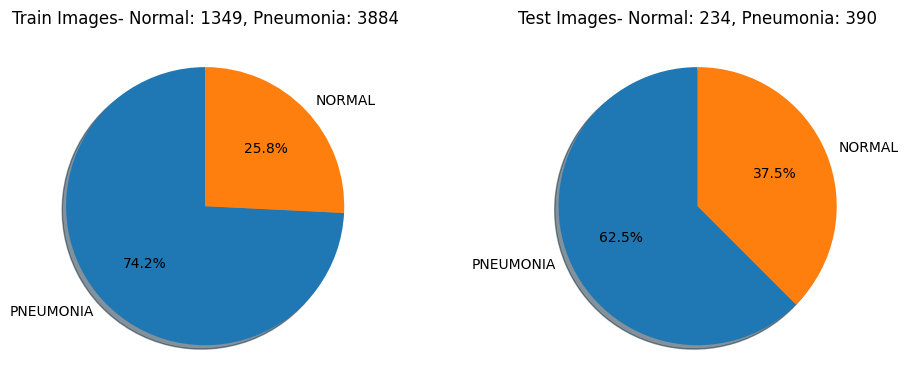

In [ ]:
Data_Train = '/content/chest_xray/train'
Data_Test = '/content/chest_xray/test'

class_names = [name for name in os.listdir(Data_Train) if not name.startswith('.')]
train_imgs = {}
test_imgs = {}
for i in class_names:
    train_imgs[i] = len(os.listdir(os.path.join(Data_Train, i)))

for i in class_names:
    test_imgs[i] = len(os.listdir(os.path.join(Data_Test, i)))


# Train data
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].pie(train_imgs.values(),
          labels=train_imgs.keys(),
          shadow=True,
          autopct='%1.1f%%',
          startangle=90)
ax[0].set_title(f'Train Images- Normal: {train_imgs["NORMAL"]}, Pneumonia: {train_imgs["PNEUMONIA"]}')

# Test data
ax[1].pie(test_imgs.values(),
          labels=test_imgs.keys(),
          shadow=True,
          autopct='%1.1f%%',
          startangle=90)
ax[1].set_title(f'Test Images- Normal: {test_imgs["NORMAL"]}, Pneumonia: {test_imgs["PNEUMONIA"]}')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
Pneumonia_Path = '/content/chest_xray/train/PNEUMONIA'
Normal_Path = '/content/chest_xray/train/NORMAL'

# **Visualize Some Random Images**

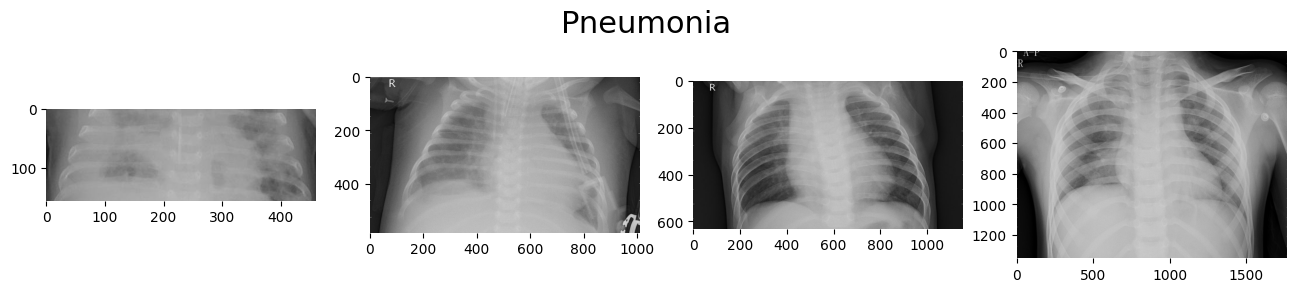

In [ ]:
fig = plt.figure(figsize=(16,3))
fig.suptitle("Pneumonia", size=22)
img_paths = os.listdir(Pneumonia_Path)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(Pneumonia_Path, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

# **Image Augmentation**

In [ ]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [.5,.5,.5]
std_nums = [.5,.5,.5]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((224,224)), #Resizes all images into same dimension
                                #transforms.RandomRotation(10), # Rotates the images upto Max of 10 Degrees
                                #transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "validation": transforms.Compose([
                                transforms.Resize((224,224)),
                                #transforms.CenterCrop(224), #Performs Crop at Center and resizes it to 120*120
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

# **Split Train Data into Train and Validation**

In [ ]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['validation'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "validation":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64) # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader, dataset_size

# Data Loaders
trainloader, valloader, dataset_size = load_split_train_test(Data_Train, .2)

dataloaders = {"train":trainloader, "validation":valloader}

data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','validation']}
class_names = trainloader.dataset.classes
print(class_names)

['NORMAL', 'PNEUMONIA']


In [ ]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Training on GPU...")
else:
    device = torch.device("cpu")
    print("Training on CPU...")

Training on GPU...


In [ ]:
torch.cuda.empty_cache()

In [ ]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()

        # input image size 3, 224, 224
        self.conv1 = nn.Conv2d(3, 32, 3, stride = 1, padding = 1)
        self.batch1 = nn.BatchNorm2d(32, affine=True, track_running_stats=True)

        # image size 8, 112, 112
        self.conv2 = nn.Conv2d(32, 56, 3, stride = 1, padding = 1)
        self.batch2 = nn.BatchNorm2d(56, affine=True, track_running_stats=True)

        # image size 16, 56, 56
        self.conv3 = nn.Conv2d(56, 64, 3, stride = 1, padding = 1)
        self.batch3 = nn.BatchNorm2d(64, affine=True, track_running_stats=True)

        self.conv4 = nn.Conv2d(64, 64, 3, stride = 1, padding = 1)
        self.batch4 = nn.BatchNorm2d(64, affine=True, track_running_stats=True)

        self.pool = nn.MaxPool2d(2, 2)

        # input size 32, 28, 28
        self.fc1 = nn.Linear(64 * 14 * 14, 4096)
        self.fc2 = nn.Linear(4096, 512)
        self.fc3 = nn.Linear(512, 64)
        self.fc4 = nn.Linear(64, 2)

        self.batch5 = nn.BatchNorm1d(512)
        self.batch6 = nn.BatchNorm1d(64)

        self.drop = nn.Dropout(p=.3)

    def forward(self, x):

        x = F.relu(self.conv1(x), inplace=True)
        x = self.pool(self.batch1(x))

        x = F.relu(self.conv2(x), inplace=True)
        x = self.pool(self.batch2(x))
        x = self.drop(x)

        x = F.relu(self.conv3(x), inplace=True)
        x = self.pool(self.batch3(x))
        x = self.drop(x)

        x = F.relu(self.conv4(x), inplace=True)
        x = self.pool(self.batch4(x))

        x = x.view(-1, 64 * 14 * 14)

        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.batch5(x)
        x = self.drop(x)
        x = F.relu(self.fc3(x))
        x = self.batch6(x)
        x = self.drop(x)
        x = self.fc4(x)

        return x

# Instantiate the model
model = CNN_Model()

if torch.cuda.is_available():
    model.cuda()

In [ ]:
from torchsummary import summary
import torch.nn as nn
summary(model, (3, 224, 224))  # Assuming input shape is (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 56, 112, 112]          16,184
       BatchNorm2d-5         [-1, 56, 112, 112]             112
         MaxPool2d-6           [-1, 56, 56, 56]               0
           Dropout-7           [-1, 56, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          32,320
       BatchNorm2d-9           [-1, 64, 56, 56]             128
        MaxPool2d-10           [-1, 64, 28, 28]               0
          Dropout-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          36,928
      BatchNorm2d-13           [-1, 64, 28, 28]             128
        MaxPool2d-14           [-1, 64,

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 50)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'validation':
                #epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            if phase == 'validation' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        train_loss_history.append(epoch_loss)
        val_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        val_acc_history.append(epoch_acc)

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=2):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} Predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# **Specify Training Option**

In [ ]:
# Specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Specify optimizer which performs Gradient Descent, Learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Learning Scheduler

In [ ]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
--------------------------------------------------


train:   0%|          | 0/66 [00:00<?, ?it/s]

train Loss: 0.2652 | train Accuracy: 0.9236


validation:   0%|          | 0/17 [00:00<?, ?it/s]

validation Loss: 0.2708 | validation Accuracy: 0.9101
Val loss Decreased from inf to 0.2708 
Saving Weights... 
Epoch 2/10
--------------------------------------------------


train:   0%|          | 0/66 [00:00<?, ?it/s]

train Loss: 0.2428 | train Accuracy: 0.9384


validation:   0%|          | 0/17 [00:00<?, ?it/s]

validation Loss: 0.2496 | validation Accuracy: 0.9140
Val loss Decreased from 0.2708 to 0.2496 
Saving Weights... 
Epoch 3/10
--------------------------------------------------


train:   0%|          | 0/66 [00:00<?, ?it/s]

train Loss: 0.2539 | train Accuracy: 0.9317


validation:   0%|          | 0/17 [00:00<?, ?it/s]

validation Loss: 0.2182 | validation Accuracy: 0.9264
Val loss Decreased from 0.2496 to 0.2182 
Saving Weights... 
Epoch 4/10
--------------------------------------------------


train:   0%|          | 0/66 [00:00<?, ?it/s]

train Loss: 0.2472 | train Accuracy: 0.9362


validation:   0%|          | 0/17 [00:00<?, ?it/s]

validation Loss: 0.3688 | validation Accuracy: 0.9140
Epoch 5/10
--------------------------------------------------


train:   0%|          | 0/66 [00:00<?, ?it/s]

train Loss: 0.2446 | train Accuracy: 0.9365


validation:   0%|          | 0/17 [00:00<?, ?it/s]

validation Loss: 0.6738 | validation Accuracy: 0.8881
Epoch 6/10
--------------------------------------------------


train:   0%|          | 0/66 [00:00<?, ?it/s]

train Loss: 0.2469 | train Accuracy: 0.9374


validation:   0%|          | 0/17 [00:00<?, ?it/s]

validation Loss: 0.2149 | validation Accuracy: 0.9283
Val loss Decreased from 0.2182 to 0.2149 
Saving Weights... 
Epoch 7/10
--------------------------------------------------


train:   0%|          | 0/66 [00:00<?, ?it/s]

train Loss: 0.2484 | train Accuracy: 0.9329


validation:   0%|          | 0/17 [00:00<?, ?it/s]

validation Loss: 0.2471 | validation Accuracy: 0.9149
Epoch 8/10
--------------------------------------------------


train:   0%|          | 0/66 [00:00<?, ?it/s]

train Loss: 0.2468 | train Accuracy: 0.9360


validation:   0%|          | 0/17 [00:00<?, ?it/s]

validation Loss: 0.7304 | validation Accuracy: 0.8872
Epoch 9/10
--------------------------------------------------


train:   0%|          | 0/66 [00:00<?, ?it/s]

train Loss: 0.2382 | train Accuracy: 0.9424


validation:   0%|          | 0/17 [00:00<?, ?it/s]

validation Loss: 0.4404 | validation Accuracy: 0.9034
Epoch 10/10
--------------------------------------------------


train:   0%|          | 0/66 [00:00<?, ?it/s]

train Loss: 0.2444 | train Accuracy: 0.9384


validation:   0%|          | 0/17 [00:00<?, ?it/s]

validation Loss: 0.2502 | validation Accuracy: 0.9178
Training complete in 15m 13s
Best val loss: 0.2149


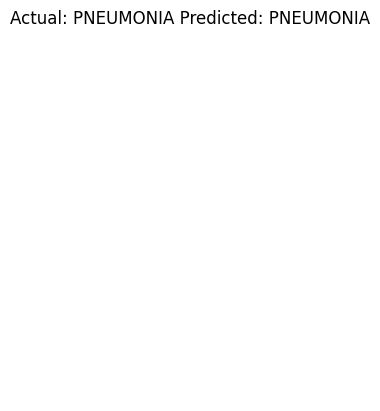

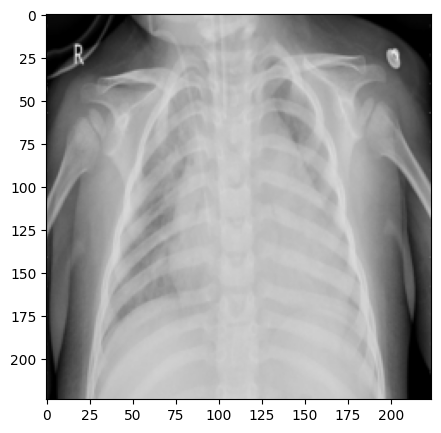

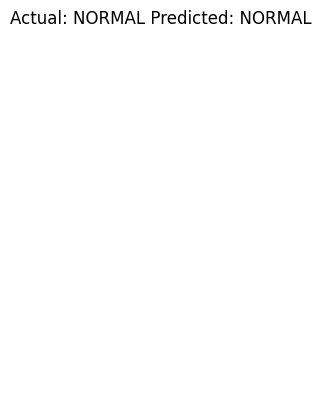

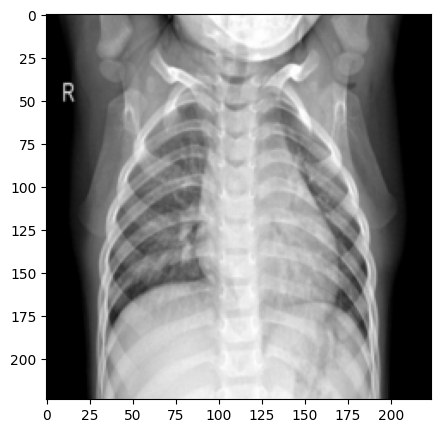

In [ ]:
visualize_model(base_model)
plt.show()

In [ ]:
test_transforms = transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_nums, std=std_nums)
])


test_image = datasets.ImageFolder(Data_Test, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=1)

In [ ]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/624 [00:00<?, ?it/s]

In [ ]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [ ]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.92      0.15      0.25       234
           1       0.66      0.99      0.79       390

    accuracy                           0.67       624
   macro avg       0.79      0.57      0.52       624
weighted avg       0.76      0.67      0.59       624



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

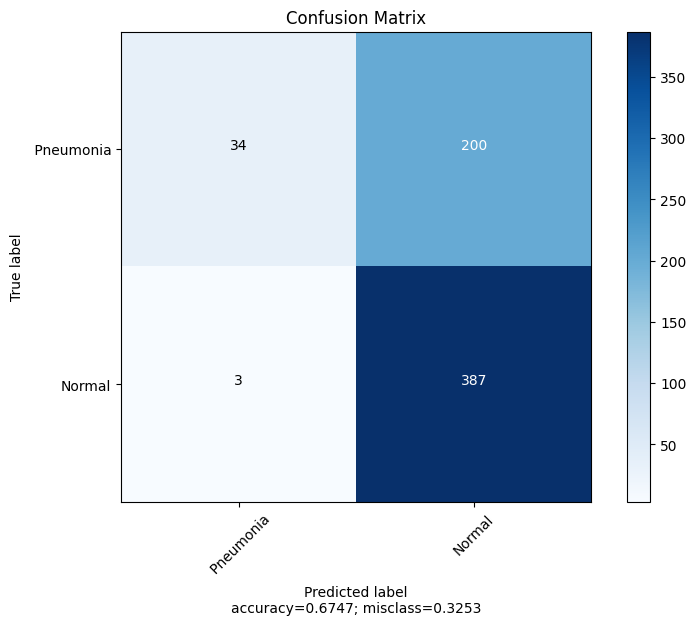

In [ ]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = [' Pneumonia','Normal'],
                      title        = "Confusion Matrix")

In [ ]:
torch.save(base_model.state_dict(), './best_model.pth')